In [1]:
#importing relevant libraries

import numpy as np 
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit    #for fitting an exponential


In [84]:
#relevant constants
pc = 3.086e18                   #cm
pi = np.pi

#galaxy specific constants (taken from SS21_ch11)
r = 10*(10**3)*pc           #radius in cm
omega = 6.481*(10**(-18))   #angular velocity in s^-1
h = 0.5*(10**3)*pc          #height in cm
eta_T = 10**26              #Diffusion coefficient in cm^2 s^-1
t0 = h*h/eta_T              #diffusion time in s
print('time stepping is normalised to t0(s) = ', t0)

time stepping is normalised to t0(s) =  2.380849e+16


In [67]:
#defining the grid, seed fields and timestepping

#grid parameters
z_res = 2*10**2                 #resolution
z0 = -1                         #lower z/h limit
zn = 1                          #upper z/h limit
dz = (zn-z0)/z_res              #step size
z = np.linspace(z0, zn, z_res)  #normalised to scale height h

#time parameters
steps = 2*10**4
dt = 8*10**(-6)
t0 = 0

#the solution is stable when 2*dt/(dz**2) < 1

#defining different seed fields that satisy the 
#boundary condition B(z = 1 and z = -1) = 0

#Seed 1: a cosine field
Br0 = np.cos(pi*z/2)
Bp0 = np.cos(pi*z/2)   

#Seed 2: a cos^2 field
Br1 = Br0*Br0        
Bp1 = Bp0*Bp0    

#Seed 3: a sum of many fields
Br2 = np.cos(pi*z/2) + np.sin(pi*z) + np.sin(2*pi*z) + np.cos(3*pi*z/2) + np.cos(7*pi*z/2) + np.sin(6*pi*z) + np.sin(7*pi*z)            
Bp2 = np.cos(pi*z/2) + np.sin(pi*z) + np.sin(2*pi*z) + np.cos(3*pi*z/2) + np.cos(7*pi*z/2) + np.sin(6*pi*z) + np.sin(7*pi*z)

#Seed 4: Different seed field form of Br and Bp
Br3 = np.cos(pi*z/2)
Bp3 = np.cos(3*pi*z/2)

In [70]:
def rk2_o2(z, t0, y0, y_0, y_n, dt, n, z_res):    #2nd order Runge-Kutta
                                                  #2nd order finite difference
    #z is the normalised height
    #t0 is the initial time
    #y0 is the initial value of the function
    #y_0 is the boundary condition of the function at z = -1, array of size n
    #y_n is the boundary condition of the function at z = 1, array of size n
    #dt is the time step
    #n is the number of steps to take
    #z_res is the resolution of the finite difference

    dz = (z[-1] - z[0])/z_res
    
    #finite difference of initial value
    #dd = np.sum(np.array([[1], [-2], [1]]) * np.array([y0[:-2], y0[1:-1], y0[2:]])/(dx**2), axis = 0)

    t_vals = np.array([t0])     #initialise time array
    y_vals = np.array([y0])                 #initialise function value array

    for i in range(n):

        t = t_vals[-1]          #current time
        y = y_vals[-1]          #current value of the function

        #value of y at 1st zone comes from boundary
        y_new = np.array([y_0[2*i+2]])

        #k1 is evaluated from j = 1 to n-1
        k1 = np.array(((y[:-2]) -2*(y[1:-1]) + (y[2:]))/(dz**2))

        #k2 is evaluated from j = 1 to n-1
        k2 = np.array([((y_0[2*i+1]) - 2*(y[1] + (dt/2)*k1[1]) + (y[2] + (dt/2)*k1[2]))/(dz**2)])[0]
        k2 = np.append(k2, np.array([((y[1:-3] + (dt/2)*k1[:-2]) - 2*(y[2:-2] + (dt/2)*k1[1:-1]) + (y[3:-1] + (dt/2)*k1[2:]))/(dz**2)])[0])
        k2 = np.append(k2, np.array([((y[-3] + (dt/2)*k1[-2]) - 2*(y[-2] + (dt/2)*k1[-1]) + 1*(y_n[2*i+1]))/(dz**2)])[0])

        y_new = np.append(y_new, y[1:-1] + (dt*k2))
        y_new = np.append(y_new, y_n[2*i+2])    #value of y at last zone comes from boundary

        y_vals = np.append(y_vals, np.array([y_new]), axis = 0)   #append the new value to the array
        t_vals = np.append(t_vals, t + dt)                       #append the new time to the array

    return t_vals, y_vals

#functions for exponential fit
def exp(t, A, b):
    return A * np.exp(b * t)

def fit_exp(data, t):
    #Fit exponential curve to the data
    popt, pcov = curve_fit(exp, t, data)

    return popt  # Return parameters A and b of the fit

In [16]:
#solving the diffusion equation for each seed field

#Boundary conditions array for the seed fields
#I have defined the boundary conditions to be zero at the boundaries
#at each timestep and also half timestep(since it is required while
#solving rk2). The size should be 2*step size, the extra 1 is added
#to match the array size only(B_bound[0] is not used in the calculation)
B_bound = np.zeros(2*steps+1)

t, sol_Br0 = rk2_o2(z, t0, Br0, B_bound, B_bound, dt, steps, z_res)
t, sol_Bp0 = rk2_o2(z, t0, Bp0, B_bound, B_bound, dt, steps, z_res)

t, sol_Br1 = rk2_o2(z, t0, Br1, B_bound, B_bound, dt, steps, z_res)
t, sol_Bp1 = rk2_o2(z, t0, Bp1, B_bound, B_bound, dt, steps, z_res)

t, sol_Br2 = rk2_o2(z, t0, Br2, B_bound, B_bound, dt, steps, z_res)
t, sol_Bp2 = rk2_o2(z, t0, Bp2, B_bound, B_bound, dt, steps, z_res)

In [68]:
t, sol_Br3 = rk2_o2(z, t0, Br3, B_bound, B_bound, dt, steps, z_res)
t, sol_Bp3 = rk2_o2(z, t0, Bp3, B_bound, B_bound, dt, steps, z_res)

#### Since the equations for Br and Bp are decoupled, we can solve them independently. The evolution of both Br and Bp will be same, and hence we can plot the evolution of Br only.

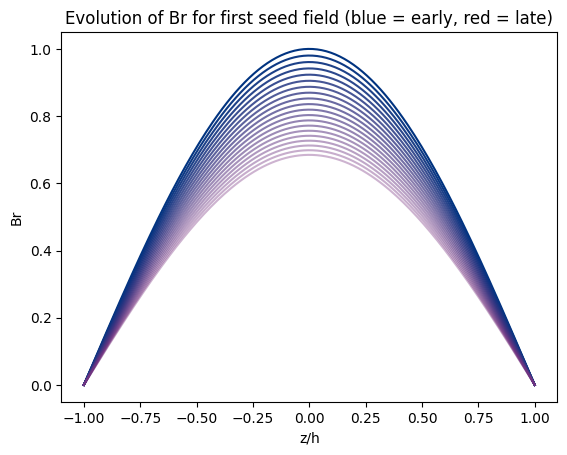

In [57]:
#plotting the evolution of Br for first seed field

i = 0
while i < steps:
    plt.plot(z, sol_Br0[i], color = (round(i/(2*steps), 5), 0.2, 0.5, round(1-i/(1.5*steps), 5)))
    i += 1000
plt.xlabel('z/h')
plt.ylabel('Br')
plt.title('Evolution of Br for first seed field (blue = early, red = late)')
plt.show()
plt.close()

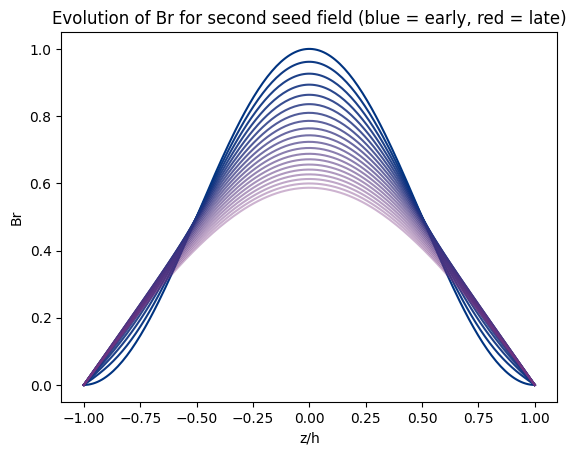

In [58]:
#plotting the evolution of Br for second seed field

i = 0
while i < steps:
    plt.plot(z, sol_Br1[i], color = (round(i/(2*steps), 5), 0.2, 0.5, round(1-i/(1.5*steps), 5)))
    i += 1000
plt.xlabel('z/h')
plt.ylabel('Br')
plt.title('Evolution of Br for second seed field (blue = early, red = late)')
plt.show()
plt.close()

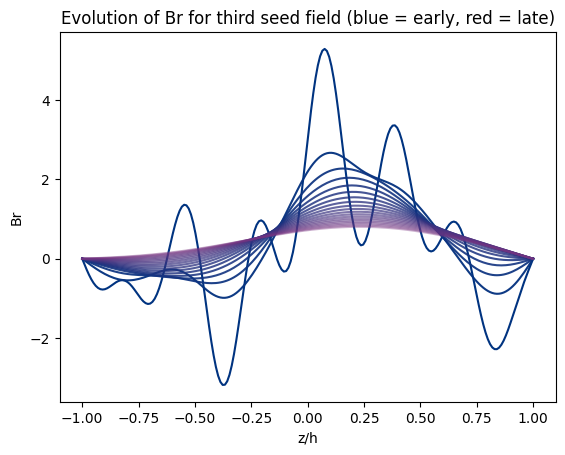

In [59]:
#plotting the evolution of Br for third seed field

i = 0
while i < steps:
    plt.plot(z, sol_Br2[i], color = (round(i/(2*steps), 5), 0.2, 0.5, round(1-i/(1.5*steps), 5)))
    i += 1000
plt.xlabel('z/h')
plt.ylabel('Br')
plt.title('Evolution of Br for third seed field (blue = early, red = late)')
plt.show()
plt.close()

#### We can see that the high frequency components of the seed field decay faster than the low frequency components, as the sharp peaks are smoothened earlier than the large scale features, like the sinusoidal component which persists for longer times(last red curve)

The exponential fit for the time evolution of Br at z = 0 is:
For first seed field, A =  0.9999688441762341 and b =  -2.492209562113454
For first seed field, A =  0.9696545549600274 and b =  -3.476033918884915
For first seed field, A =  2.200704258524398 and b =  -9.203766639385316
where A is the amplitude and b is the decay constant


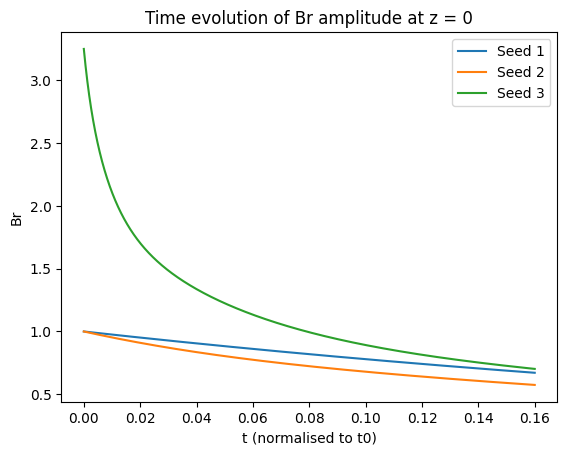

In [83]:
#fixing any z value and plotting the evolution of Br with time
#I will fix z = 0

#Saving array of B at z = 0
Br0_z0 = sol_Br0[:, z_res//2]
Br1_z0 = sol_Br1[:, z_res//2]
Br2_z0 = sol_Br2[:, z_res//2]

#fitting to exponential Aexp(bt)
A0, b0 = fit_exp(Br0_z0, t)
A1, b1 = fit_exp(Br1_z0, t)
A2, b2 = fit_exp(Br2_z0, t)

print("The exponential fit for the time evolution of Br at z = 0 is:")
print("For first seed field, A = ", A0 ,"and b = ", b0)
print("For first seed field, A = ", A1 ,"and b = ", b1)
print("For first seed field, A = ", A2 ,"and b = ", b2)
print("where A is the amplitude and b is the decay constant")

#plotting the time evolution of magnitude
plt.plot(t, Br0_z0, label = 'Seed 1')
plt.plot(t, Br1_z0, label = 'Seed 2')
plt.plot(t, Br2_z0, label = 'Seed 3')
plt.title('Time evolution of Br amplitude at z = 0')
plt.xlabel('t (normalised to t0)')
plt.ylabel('Br')
plt.legend()
plt.show()
plt.close()

#### We can quantitatively see that there is a faster decay for seed fields with more high frequency components

#### As the evolution of the seed field for the first three seed fields is exactly the same for both Br and Bp, the pitch angle would be constant(=1) throughout, so I defined a fourth seed field such that it is different for both Br and Bp. I am not sure if this is physically consistent, but theoretically we can assume different seed fields, so I attempted it. In this case, I study the evolution of the pitch angle now.

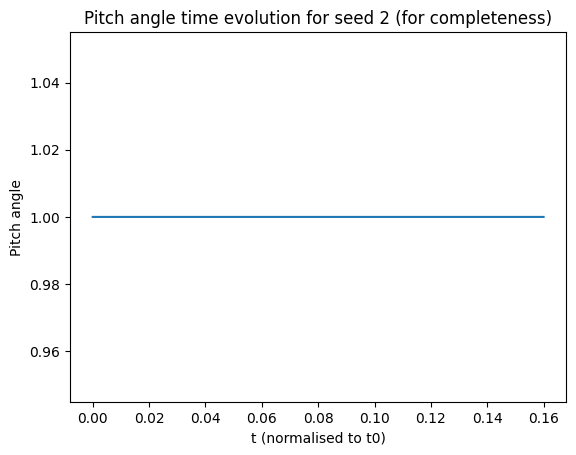

In [87]:
#evaluating the pitch angle for seed 2, just to check if it is constant
Bp2_z0 = sol_Bp2[:, z_res//2]
pitch_angle_2 = Br2_z0/Bp2_z0

#plotting the pitch angle time evolution
plt.plot(t, pitch_angle_2)
plt.title('Pitch angle time evolution for seed 2 (for completeness)')
plt.xlabel('t (normalised to t0)')
plt.ylabel('Pitch angle')
plt.show()
plt.close()

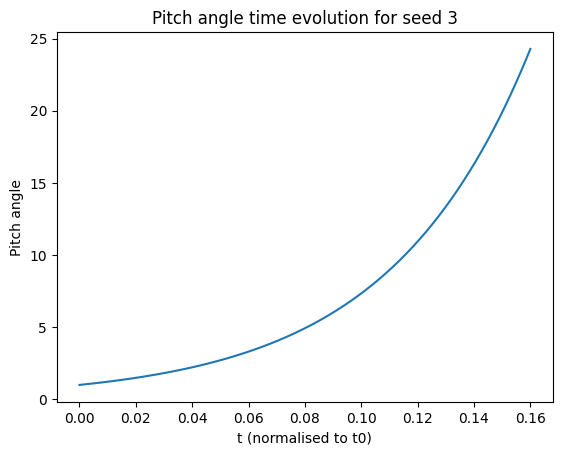

In [85]:
#evaluating the pitch angle for seed 3
Br3_z0 = sol_Br3[:, z_res//2]
Bp3_z0 = sol_Bp3[:, z_res//2]
pitch_angle_3 = Br3_z0/Bp3_z0

#plotting the pitch angle time evolution
plt.plot(t, pitch_angle_3)
plt.title('Pitch angle time evolution for seed 3')
plt.xlabel('t (normalised to t0)')
plt.ylabel('Pitch angle')
plt.show()
plt.close()

#### We can see that the pitch angle increases. This is because the B_phi component is of a higher frequency, and hence decays faster than the B_r component, and hence as a result the pitch angle increases with time. Moreover, this increase in exponential in nature because B_phi and B_r both evolve exponentially.

#### I attempted to solve the diffusion equation with higher order Runge Kutta (RK4) and higher order finite differencing (O6), but the code did not work, so I am still working on it. I have referenced my code here just for completeness. I have not been able to figure out how to self consistently implement other boundary conditions yet, so that is also a work in progress.

# In progress !!!

In [ ]:
def fd6_o2(y, dx):                  #6th order finite difference 
    
    dd = np.sum(np.array([[812], [-3132], [5265], [-5080], [2970], [-972], [137]]) * np.array([[y[0]], [y[1]], [y[2]], [y[3]], [y[4]], [y[5]], [y[6]]])/(180*dx**2), axis = 0)
    dd = np.append(dd, np.sum(np.array([[137], [-147], [-255], [470], [-285], [93], [-13]]) * np.array([[y[0]], [y[1]], [y[2]], [y[3]], [y[4]], [y[5]], [y[6]]])/(180*dx**2), axis = 0)[0])
    dd = np.append(dd, np.sum(np.array([[-13], [228], [-420], [200], [15], [-12], [2]]) * np.array([[y[0]], [y[1]], [y[2]], [y[3]], [y[4]], [y[5]], [y[6]]])/(180*dx**2), axis = 0)[0])
    dd = np.append(dd, np.sum(np.array([[2], [-27], [270], [-490], [270], [-27], [2]]) * np.array([y[:-6], y[1:-5], y[2:-4], y[3:-3], y[4:-2], y[5:-1], y[6:]])/(180*dx**2), axis = 0))
    dd = np.append(dd, np.sum(np.array([[-13], [228], [-420], [200], [15], [-12], [2]]) * np.array([[y[-1]], [y[-2]], [y[-3]], [y[-4]], [y[-5]], [y[-6]], [y[-7]]])/(180*dx**2), axis = 0)[0])
    dd = np.append(dd, np.sum(np.array([[137], [-147], [-255], [470], [-285], [93], [-13]]) * np.array([[y[-1]], [y[-2]], [y[-3]], [y[-4]], [y[-5]], [y[-6]], [y[-7]]])/(180*dx**2), axis = 0)[0])
    dd = np.append(dd, np.sum(np.array([[812], [-3132], [5265], [-5080], [2970], [-972], [137]]) * np.array([[y[-1]], [y[-2]], [y[-3]], [y[-4]], [y[-5]], [y[-6]], [y[-7]]])/(180*dx**2), axis = 0)[0])

    return dd

In [ ]:
def rk4_o6(z, t0, y0, y_0, y_n, dt, n, res):    #4th order Runge-Kutta
                                                #6th order finite difference

    #z is the normalised height
    #t0 is the initial time
    #y0 is the initial value of the function
    #y_0 is the boundary condition of the function at z = -1, array of size n
    #y_n is the boundary condition of the function at z = 1, array of size n
    #dt is the time step
    #n is the number of steps to take
    #res is the resolution of the finite difference

    dx = (z[-1] - z[0])/res
    t_vals = np.array([t0])     #initialise time array
    y_vals = np.array([y0])     #initialise function value array - in our
                                #case this will be double derivative of B
    
    for i in range(n):
        k1 = np.array([])
        k2 = np.array([])
        k3 = np.array([])
        k4 = np.array([])

        t = t_vals[-1]          #current time
        y = y_vals[-1]          #current value of the function

        y_new = np.array([y_0[2*i+2]])
        #k1 is simply the second derivative of the seed field
        k1 = np.append(k1, y)

        #k2 is evaluated at (t + dt/2, y + k1*dt/2)
        k2 = np.append(k2, np.sum(np.array([[812], [-3132], [5265], [-5080], [2970], [-972], [137]]) * np.array([[y_0[2*i+1]], [y[1] + (dt/2)*k1[1]], [y[2] + (dt/2)*k1[2]], [y[3] + (dt/2)*k1[3]], [y[4] + (dt/2)*k1[4]], [y[5] + (dt/2)*k1[5]], [y[6] + (dt/2)*k1[6]]])/(180*dx**2), axis = 0)[0])
        k2 = np.append(k2, np.sum(np.array([[137], [-147], [-255], [470], [-285], [93], [-13]]) * np.array([[y_0[2*i+1]], [y[1] + (dt/2)*k1[1]], [y[2] + (dt/2)*k1[2]], [y[3] + (dt/2)*k1[3]], [y[4] + (dt/2)*k1[4]], [y[5] + (dt/2)*k1[5]], [y[6] + (dt/2)*k1[6]]])/(180*dx**2), axis = 0)[0])
        k2 = np.append(k2, np.sum(np.array([[-13], [228], [-420], [200], [15], [-12], [2]]) * np.array([[y_0[2*i+1]], [y[1] + (dt/2)*k1[1]], [y[2] + (dt/2)*k1[2]], [y[3] + (dt/2)*k1[3]], [y[4] + (dt/2)*k1[4]], [y[5] + (dt/2)*k1[5]], [y[6] + (dt/2)*k1[6]]])/(180*dx**2), axis = 0)[0])
        k2 = np.append(k2, np.sum(np.array([[2], [-27], [270], [-490], [270], [-27], [2]]) * np.array([y[:-6] + (dt/2)*k1[:-6], y[1:-5] + (dt/2)*k1[1:-5], y[2:-4] + (dt/2)*k1[2:-4], y[3:-3] + (dt/2)*k1[3:-3], y[4:-2] + (dt/2)*k1[4:-2], y[5:-1] + (dt/2)*k1[5:-1], y[6:] + (dt/2)*k1[6:]])/(180*dx**2), axis = 0))
        k2 = np.append(k2, np.sum(np.array([[-13], [228], [-420], [200], [15], [-12], [2]]) * np.array([[y_n[2*i+1]], [y[-2] + (dt/2)*k1[-2]], [y[-3] + (dt/2)*k1[-3]], [y[-4] + (dt/2)*k1[-4]], [y[-5] + (dt/2)*k1[-5]], [y[-6] + (dt/2)*k1[-6]], [y[-7] + (dt/2)*k1[-7]]])/(180*dx**2), axis = 0)[0])
        k2 = np.append(k2, np.sum(np.array([[137], [-147], [-255], [470], [-285], [93], [-13]]) * np.array([[y_n[2*i+1]], [y[-2] + (dt/2)*k1[-2]], [y[-3] + (dt/2)*k1[-3]], [y[-4] + (dt/2)*k1[-4]], [y[-5] + (dt/2)*k1[-5]], [y[-6] + (dt/2)*k1[-6]], [y[-7] + (dt/2)*k1[-7]]])/(180*dx**2), axis = 0)[0])
        k2 = np.append(k2, np.sum(np.array([[812], [-3132], [5265], [-5080], [2970], [-972], [137]]) * np.array([[y_n[2*i+1]], [y[-2] + (dt/2)*k1[-2]], [y[-3] + (dt/2)*k1[-3]], [y[-4] + (dt/2)*k1[-4]], [y[-5] + (dt/2)*k1[-5]], [y[-6] + (dt/2)*k1[-6]], [y[-7] + (dt/2)*k1[-7]]])/(180*dx**2), axis = 0)[0])

        #k3 is evaluated at (t + dt/2, y + k2*dt/2)
        k3 = np.append(k3, np.sum(np.array([[812], [-3132], [5265], [-5080], [2970], [-972], [137]]) * np.array([[y_0[2*i+1]], [y[1] + (dt/2)*k2[1]], [y[2] + (dt/2)*k2[2]], [y[3] + (dt/2)*k2[3]], [y[4] + (dt/2)*k2[4]], [y[5] + (dt/2)*k2[5]], [y[6] + (dt/2)*k2[6]]])/(180*dx**2), axis = 0)[0])
        k3 = np.append(k3, np.sum(np.array([[137], [-147], [-255], [470], [-285], [93], [-13]]) * np.array([[y_0[2*i+1]], [y[1] + (dt/2)*k2[1]], [y[2] + (dt/2)*k2[2]], [y[3] + (dt/2)*k2[3]], [y[4] + (dt/2)*k2[4]], [y[5] + (dt/2)*k2[5]], [y[6] + (dt/2)*k2[6]]])/(180*dx**2), axis = 0)[0])
        k3 = np.append(k3, np.sum(np.array([[-13], [228], [-420], [200], [15], [-12], [2]]) * np.array([[y_0[2*i+1]], [y[1] + (dt/2)*k2[0]], [y[2] + (dt/2)*k2[1]], [y[3] + (dt/2)*k2[2]], [y[4] + (dt/2)*k2[3]], [y[5] + (dt/2)*k2[4]], [y[6] + (dt/2)*k2[5]]])/(180*dx**2), axis = 0)[0])
        k3 = np.append(k3, np.sum(np.array([[2], [-27], [270], [-490], [270], [-27], [2]]) * np.array([y[:-6] + (dt/2)*k2[:-6], y[1:-5] + (dt/2)*k2[1:-5], y[2:-4] + (dt/2)*k2[2:-4], y[3:-3] + (dt/2)*k2[3:-3], y[4:-2] + (dt/2)*k2[4:-2], y[5:-1] + (dt/2)*k2[5:-1], y[6:] + (dt/2)*k2[6:]])/(180*dx**2), axis = 0))
        k3 = np.append(k3, np.sum(np.array([[-13], [228], [-420], [200], [15], [-12], [2]]) * np.array([[y_n[2*i+1]], [y[-2] + (dt/2)*k2[-2]], [y[-3] + (dt/2)*k2[-3]], [y[-4] + (dt/2)*k2[-4]], [y[-5] + (dt/2)*k2[-5]], [y[-6] + (dt/2)*k2[-6]], [y[-7] + (dt/2)*k2[-7]]])/(180*dx**2), axis = 0)[0])
        k3 = np.append(k3, np.sum(np.array([[137], [-147], [-255], [470], [-285], [93], [-13]]) * np.array([[y_n[2*i+1]], [y[-2] + (dt/2)*k2[-2]], [y[-3] + (dt/2)*k2[-3]], [y[-4] + (dt/2)*k2[-4]], [y[-5] + (dt/2)*k2[-5]], [y[-6] + (dt/2)*k2[-6]], [y[-7] + (dt/2)*k2[-7]]])/(180*dx**2), axis = 0)[0])
        k3 = np.append(k3, np.sum(np.array([[812], [-3132], [5265], [-5080], [2970], [-972], [137]]) * np.array([[y_n[2*i+1]], [y[-2] + (dt/2)*k2[-2]], [y[-3] + (dt/2)*k2[-3]], [y[-4] + (dt/2)*k2[-4]], [y[-5] + (dt/2)*k2[-5]], [y[-6] + (dt/2)*k2[-6]], [y[-7] + (dt/2)*k2[-7]]])/(180*dx**2), axis = 0)[0])

        #k4 is evaluated at (t + dt, y + k3*dt)
        k4 = np.append(k4, np.sum(np.array([[812], [-3132], [5265], [-5080], [2970], [-972], [137]]) * np.array([[y_0[2*i+2]], [y[1] + dt*k3[1]], [y[2] + dt*k3[2]], [y[3] + dt*k3[3]], [y[4] + dt*k3[4]], [y[5] + dt*k3[5]], [y[6] + dt*k3[6]]])/(180*dx**2), axis = 0)[0])
        k4 = np.append(k4, np.sum(np.array([[137], [-147], [-255], [470], [-285], [93], [-13]]) * np.array([[y_0[2*i+2]], [y[1] + dt*k3[1]], [y[2] + dt*k3[2]], [y[3] + dt*k3[3]], [y[4] + dt*k3[4]], [y[5] + dt*k3[5]], [y[6] + dt*k3[6]]])/(180*dx**2), axis = 0)[0])
        k4 = np.append(k4, np.sum(np.array([[-13], [228], [-420], [200], [15], [-12], [2]]) * np.array([[y_0[2*i+2]], [y[1] + dt*k3[1]], [y[2] + dt*k3[2]], [y[3] + dt*k3[3]], [y[4] + dt*k3[4]], [y[5] + dt*k3[5]], [y[6] + dt*k3[6]]])/(180*dx**2), axis = 0)[0])
        k4 = np.append(k4, np.sum(np.array([[2], [-27], [270], [-490], [270], [-27], [2]]) * np.array([y[:-6] + dt*k3[:-6], y[1:-5] + dt*k3[1:-5], y[2:-4] + dt*k3[2:-4], y[3:-3] + dt*k3[3:-3], y[4:-2] + dt*k3[4:-2], y[5:-1] + dt*k3[5:-1], y[6:] + dt*k3[6:]])/(180*dx**2), axis = 0))
        k4 = np.append(k4, np.sum(np.array([[-13], [228], [-420], [200], [15], [-12], [2]]) * np.array([[y_n[2*i+2]], [y[-2] + dt*k3[-2]], [y[-3] + dt*k3[-3]], [y[-4] + dt*k3[-4]], [y[-5] + dt*k3[-5]], [y[-6] + dt*k3[-6]], [y[-7] + dt*k3[-7]]])/(180*dx**2), axis = 0)[0])
        k4 = np.append(k4, np.sum(np.array([[137], [-147], [-255], [470], [-285], [93], [-13]]) * np.array([[y_n[2*i+2]], [y[-2] + dt*k3[-2]], [y[-3] + dt*k3[-3]], [y[-4] + dt*k3[-4]], [y[-5] + dt*k3[-5]], [y[-6] + dt*k3[-6]], [y[-7] + dt*k3[-7]]])/(180*dx**2), axis = 0)[0])
        k4 = np.append(k4, np.sum(np.array([[812], [-3132], [5265], [-5080], [2970], [-972], [137]]) * np.array([[y_n[2*i+2]], [y[-2] + dt*k3[-2]], [y[-3] + dt*k3[-3]], [y[-4] + dt*k3[-4]], [y[-5] + dt*k3[-5]], [y[-6] + dt*k3[-6]], [y[-7] + dt*k3[-7]]])/(180*dx**2), axis = 0)[0])
        
        #update the function value
        y_new = np.append(y_new, y[1:-1] + (dt/6)*(k1[1:-1] + 2*k2[1:-1] + 2*k3[1:-1] + k4[1:-1]))
        y_new = np.append(y_new, np.array([y_n[2*i+2]]))
        
        y_vals = np.append(y_vals, np.array([y_new]), axis = 0)   #append the new value to the array
        t_vals = np.append(t_vals, t + dt)                       #append the new time to the array

    return t_vals, y_vals